In [2]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os 
import copy
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib as mpl
#import collections
import matplotlib.ticker as mticker
from matplotlib import ticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean
import scipy as sp
import warnings
warnings.filterwarnings("ignore")
import os

from scipy.signal import butter, lfilter
from scipy.signal import convolve

import utilities

import importlib
def reimport_module(module_name):
    """
    Reimports the specified Python module.
    
    Args:
    module_name (module): The module to be reimported, typically passed as a variable.
    
    Returns:
    module: The reloaded module.
    """
    try:
        # Reload the already imported module
        reloaded_module = importlib.reload(module_name)
        print(f"Module {module_name.__name__} reloaded successfully.")
        return reloaded_module
    except Exception as e:
        print(f"Failed to reload module: {e}")

reimport_module(utilities)

Module utilities reloaded successfully.


<module 'utilities' from '/glade/work/wchapman/CMJO_Diagnostics_Tool/utilities.py'>

## Vars In

In [62]:
twStrt = '1979-10-01'
twLast = '1993-12-31'

cwStrt = '1979-11-01'
cwLast = '2001-05-31'

dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_meanGPU_exp001/ts/'

f_precip_in = 'f.e.FTORCHmjo_meanGPU_exp001.cam.h1.FLUT.anomalies.1979010100000-1993123100000.nc'
var_name_precip = 'FLUT'

save_Fig_out = f'{dir_in}/{f_precip_in.split(var_name_precip)[0]}HOVm_FLUT_TS.png'
print(f'saving figure to {save_Fig_out}')

saving figure to /glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_meanGPU_exp001/ts//f.e.FTORCHmjo_meanGPU_exp001.cam.h1.HOVm_FLUT_TS.png


## Region Setting:

In [63]:
latns = slice(-5, 5)   
lonlr = slice(60, 260)

# Define bandpass frequency limits
f_low = 100  # Corresponds to  days period
f_high = 20   # Corresponds to 20 days period
maxlag = 30

## Open Files

In [64]:
# precip: 
file_path_precip = os.path.join(dir_in, f_precip_in)  # Join the directory and file name
DS_precip = xr.open_dataset(file_path_precip)

# # u850: 
# file_path_u = os.path.join(dir_in, f_u_in)  # Join the directory and file name
# DS_u = xr.open_dataset(file_path_u)

#create cosine latitude weighting: 
weights = np.cos(np.deg2rad(DS_precip.lat))

## Lat/Lon averages of U and P

In [65]:
# create a LAT average
DS_precip['PRECT_timeLon'] = xr.zeros_like((DS_precip[var_name_precip]*weights).sel(lat=latns).mean('lat'))
DS_precip['PRECT_timeLon'][:] = copy.deepcopy((DS_precip[var_name_precip]*weights).sel(lat=latns).mean('lat'))
DS_precip['PRECT_timeLon_f'] = copy.deepcopy(DS_precip['PRECT_timeLon'])
DS_precip['PRECT_timeLon_f'][:] = utilities.bandpass_filter_via_fft_2d(np.array(DS_precip['PRECT_timeLon']), f_high, f_low, sampling_interval=1)

DS_precip_lonavg = copy.deepcopy((DS_precip[var_name_precip]*weights).sel(lat=lat_bounds_global,lon=lonlr).mean('lon')).to_dataset(name='PRECT_timeLat')
DS_precip_lonavg['PRECT_timeLat_f'] = copy.deepcopy(DS_precip_lonavg['PRECT_timeLat'])
DS_precip_lonavg['PRECT_timeLat_f'][:] = utilities.bandpass_filter_via_fft_2d(np.array(DS_precip_lonavg['PRECT_timeLat']), f_high, f_low, sampling_interval=1)

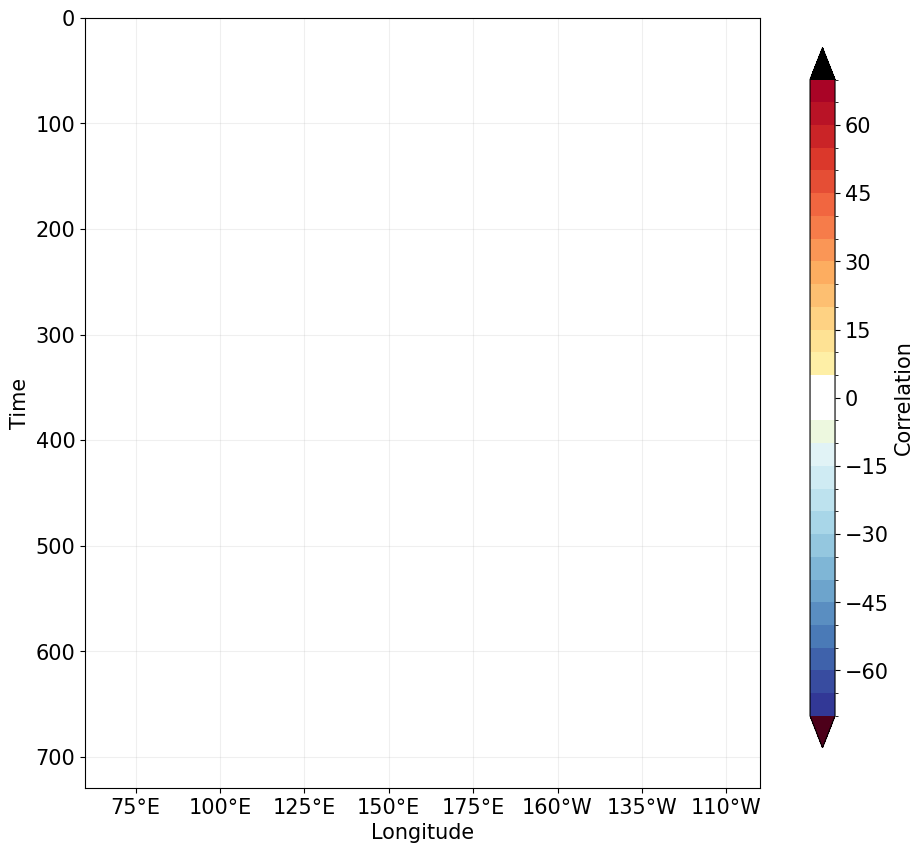

In [66]:
# define the colormap
cmap = plt.cm.RdYlBu_r
# extract all colors from the Reds map
cmaplist = [cmap(i) for i in range(cmap.N)]
# make the first color entry to be whhite
cmaplist[0] = cmap(1)
# make the last color entry to be most extreme--
cmaplist[cmap.N-1] = cmap(0.99)

for ii in range(120,136):
    cmaplist[ii]=[1,1,1,1]

cmap.N
# create the new map
cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
clevels = np.arange(-70.0,75,5)
norm = mpl.colors.BoundaryNorm(clevels, cmap.N)
cmap.set_under([0.3, 0.00, 0.1, 1.0])
cmap.set_over('k')

# Assuming that the necessary data and variables like clevels, cmap, norm, etc., are already defined
# Create a figure with two subplots (one for each variable) and share a single colorbar
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

plotter = DS_precip['PRECT_timeLon_f'].sel(lon=lonlr).sel(time=slice('1981','1982'))
tims = np.arange(0,len(plotter['time']))
lons = DS_precip['PRECT_timeLon_f'].sel(lon=lonlr)['lon']

# Plot for the first dataset
ff1 = ax1.contourf(lons, tims, plotter, levels=clevels, cmap=cmap, norm=norm, extend='both')
ax1.grid(True, alpha=0.2)
ax1.set_xlabel('Longitude', fontsize=15)
ax1.set_ylabel('Time', fontsize=15)
lon_formatter = LongitudeFormatter(number_format='.0f')
ax1.tick_params(labelsize=15) 
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.invert_yaxis()

# Create a colorbar on the right side of the plot
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])  # Adjust the colorbar position
cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, extend='both', spacing='proportional', ticks=clevels, boundaries=clevels)
cbar_ax.set_ylabel('Correlation', size=15)
cb.ax.tick_params(labelsize=15)
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig(save_Fig_out,bbox_inches='tight',dpi=400)
plt.show()